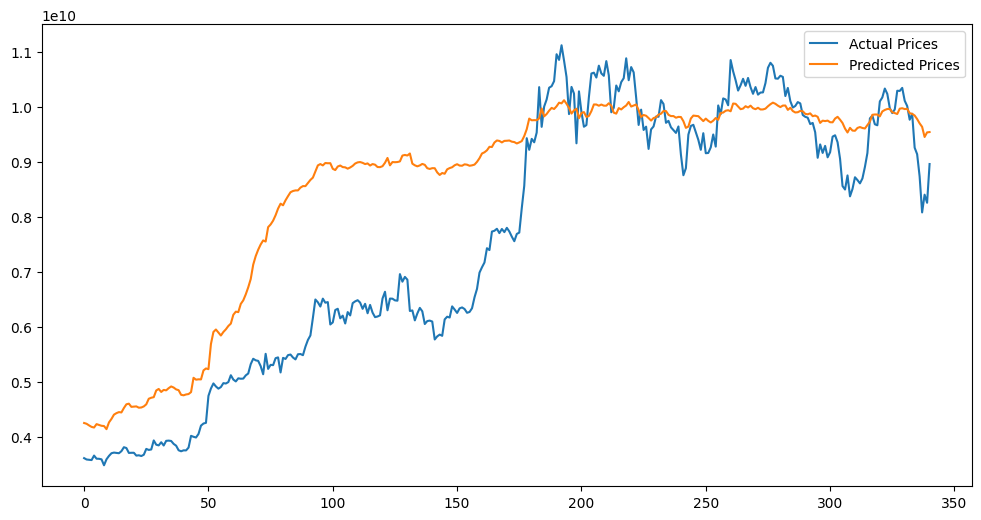

In [4]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the model class definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(2, 1, self.hidden_layer_size),
                            torch.zeros(2, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Load data from CSV files
btc_data_daily = pd.read_csv('btc_data_daily.csv', index_col='time', parse_dates=True)

# Filter numeric columns only
numeric_cols = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']
btc_data_daily = btc_data_daily[numeric_cols]

# Handle missing values by forward filling
btc_data_daily.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
btc_data_daily_scaled = scaler.fit_transform(btc_data_daily)
btc_data_daily_scaled = pd.DataFrame(btc_data_daily_scaled, columns=btc_data_daily.columns, index=btc_data_daily.index)

# Prepare data for evaluation
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Extract only the closing price for the target
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split data into training and testing sets (80-20 split)
time_steps = 60  # Use last 60 days for prediction
train_size = int(len(btc_data_daily_scaled) * 0.8)
test_size = len(btc_data_daily_scaled) - train_size
train_data, test_data = btc_data_daily_scaled[:train_size], btc_data_daily_scaled[train_size:]

X_test, y_test = prepare_data(test_data.values, time_steps)  # Convert to NumPy array

# Load the model
input_size = X_test.shape[2]
hidden_layer_size = 100  # Same as defined during training
output_size = 1
model = LSTMModel(input_size, hidden_layer_size, output_size)
model.load_state_dict(torch.load('btc_trading_model.pth'))
model.eval()

# Function to plot predictions
def plot_predictions(model, X, y):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for i in range(len(X)):
            model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),
                                 torch.zeros(2, 1, model.hidden_layer_size))
            y_pred = model(X[i].unsqueeze(0))
            predictions.append(y_pred.item())
            actuals.append(y[i].item())

    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(model, X_test, y_test)
